# Feature 

In [44]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import snownlp
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from snownlp import SnowNLP


<font size=6>Read file</font>

In [45]:
train = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/nytimes-dataset/train_30000.pkl')
train = train.drop(train[train['n_comment'] <= 0].index)
#print(train.columns)
#train = train.drop(columns = ['web_url', 'headline'])
train


,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
12,https://www.nytimes.com/2021/01/01/nyregion/85...,MB,1,Metropolitan,New York,News,1920,NaN,2021,1,...,28,0,How the Oldest Old Can Endure Even This,8,0,None,66,"[Elderly, Nursing Homes, Retirement Communitie...",[John Leland],186
14,https://www.nytimes.com/2021/01/01/climate/tru...,A,19,Climate,Climate,News,1582,NaN,2021,1,...,25,0,"How Trump Tried, but Largely Failed, to Derail...",12,0,None,49,"[Global Warming, Environment, Research, United...",[Christopher Flavelle],10
18,https://www.nytimes.com/2021/01/01/realestate/...,RE,1,RealEstate,Real Estate,News,2567,NaN,2021,1,...,22,0,New Yorkers Who Fled the Virus Are Returning H...,10,0,None,77,"[Real Estate and Housing (Residential), Rentin...",[Steven Kurutz],343
30,https://www.nytimes.com/2021/01/01/opinion/nur...,SR,5,OpEd,Opinion,Op-Ed,1556,NaN,2021,1,...,26,0,"‘Because of You Guys, I’m Stuck in My Room’",9,0,None,59,"[Quarantine (Life and Culture), Quarantines, L...",[Kristin Lin],97
45,https://www.nytimes.com/2021/01/01/crosswords/...,NaN,NaN,Games,Crosswords & Games,News,556,NaN,2021,1,...,4,0,Drink That You Could Really Use,6,0,"Wordplay, The CROSSWORD COLUMN",65,"[Crossword Puzzles, Deeney, Joe (Crossword Con...",[Caitlin Lovinger],112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39850,https://www.nytimes.com/2022/12/30/crosswords/...,NaN,NaN,Games,Crosswords & Games,News,619,NaN,2022,12,...,11,0,Get Frothy,2,0,"Wordplay, The CROSSWORD COLUMN",100,[Crossword Puzzles],[Caitlin Lovinger],113
39857,https://www.nytimes.com/interactive/2022/12/31...,NaN,NaN,The Upshot,The Upshot,Interactive Feature,0,NaN,2022,12,...,17,0,Readers Sent Us Pandemic Photos in 2020. Here’...,13,0,None,17,"[Coronavirus (2019-nCoV), Photography, Quarant...","[Alicia Parlapiano, Emily Badger, Claire Mille...",99
39866,https://www.nytimes.com/2022/12/31/books/molly...,NaN,NaN,BookReview,Books,News,819,NaN,2022,12,...,7,10,"The Jackal, the Fox and Auld Lang Syne",8,0,None,2,"[Books and Literature, internal-sub-only-nl]",[Molly Young],18
39877,https://www.nytimes.com/2022/12/31/us/politics...,NaN,NaN,Investigative,U.S.,News,7958,Politics,2022,12,...,22,0,The Invention of Elise Stefanik,5,0,None,5,"[Stefanik, Elise, Trump, Donald J, Republican ...",[Nicholas Confessore],814


<font size=6>select bound of is_popular</font>

In [46]:
median = train['n_comment'].median()
print(median)
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

58.0
popular:     0.496098104793757
not popular: 0.5039018952062431


In [47]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


<font size=6>Hour</font>


pub_time
0     0.699367
1     0.624161
2     0.686508
3     0.710692
4     0.251497
5     0.265823
6     0.269006
7     0.525362
8     0.466125
9     0.545347
10    0.518229
11    0.287273
12    0.394068
13    0.313152
14    0.362101
15    0.500000
16    0.485507
17    0.484375
18    0.373762
19    0.513953
20    0.456193
21    0.498270
22    0.523659
23    0.681093
Name: is_popular, dtype: float64
0.13373397604036077


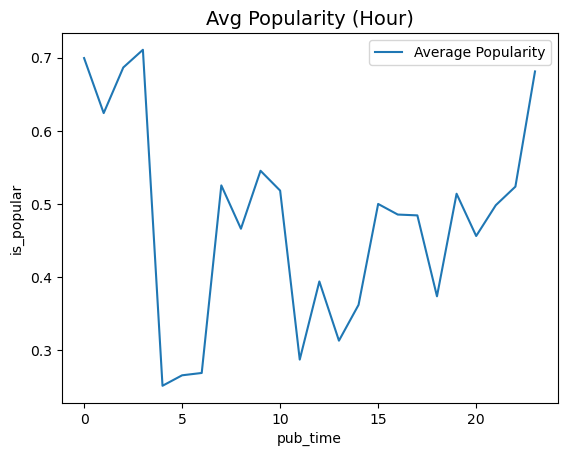

In [48]:
print(train.groupby('pub_time').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_time').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Hour)', fontsize=14)
#plt.axvline(x = 3, linestyle= '--')

train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
print(train.corr()['is_popular']['is_noon'])

<font size=6>Weekday</font>

In [49]:
print(train.groupby('pub_weekday').mean()['is_popular'])

pub_weekday
0    0.504735
1    0.494004
2    0.457762
3    0.463652
4    0.481602
5    0.713141
6    0.552891
Name: is_popular, dtype: float64


<font size=6>day of week</font>

0.09470977905951827


Text(0.5, 1.0, 'Avg Popularity (Day of Week)')

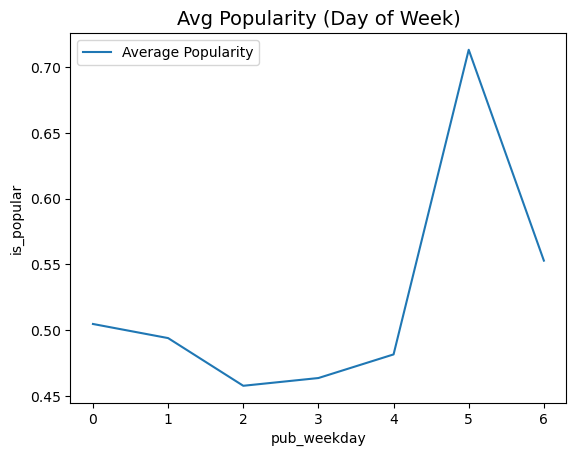

In [50]:
train['is_weekend'] = train['pub_weekday'].apply(lambda x : 1 if (x == 5 or x == 6) else 0)
print(train.corr()['is_popular']['is_weekend'])
sns.lineplot(data = train.groupby('pub_weekday').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Day of Week)', fontsize=14)


<font size=6>day of month</font>

pub_day
1     0.511936
2     0.519481
3     0.503722
4     0.543307
5     0.507246
6     0.471850
7     0.493056
8     0.482759
9     0.473418
10    0.505155
11    0.507812
12    0.498741
13    0.508728
14    0.519704
15    0.476316
16    0.505025
17    0.458974
18    0.445876
19    0.494819
20    0.509333
21    0.505000
22    0.476923
23    0.480211
24    0.502674
25    0.476584
26    0.523944
27    0.519582
28    0.510870
29    0.473545
30    0.496667
31    0.458564
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (day)')

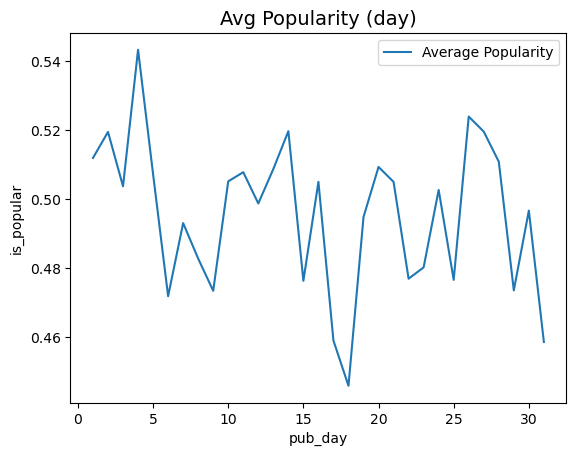

In [51]:
print(train.groupby('pub_day').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_day').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (day)', fontsize=14)
#train = train.drop(columns = ['pub_day'])
#train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
#print(train.corr()['is_popular']['is_noon'])

<font size=6>month</font>

pub_month
1     0.510972
2     0.492308
3     0.465779
4     0.477432
5     0.444329
6     0.480851
7     0.523454
8     0.516556
9     0.495069
10    0.518775
11    0.515475
12    0.516461
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (month)')

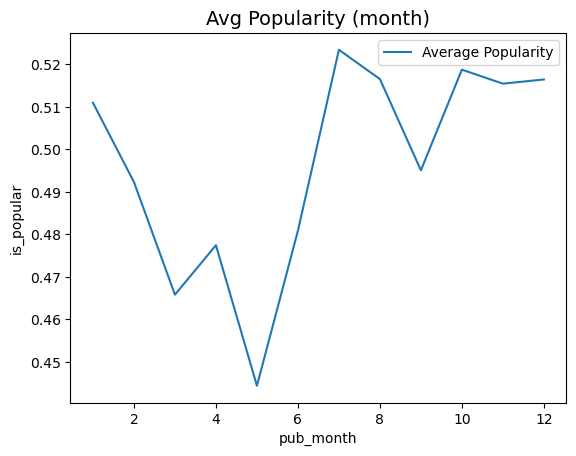

In [52]:
print(train.groupby('pub_month').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_month').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (month)', fontsize=14)
#train = train.drop(columns = ['pub_month'])
#train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
#print(train.corr()['is_popular']['is_noon'])

<font size=6>News desk</font>

In [53]:
train['group_by_news_desk'] = train['is_popular'].groupby(train['news_desk']).transform('mean')
#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular']['group_by_news_desk'])
train['feature_news_desk'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_news_desk'])

0.5276392203690563
0.5241742852440453


<font size=6>Section</font>

In [54]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.513286037396327
0.5241742852440473


<font size=6>Section</font>

In [55]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
#train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.513286037396327
0.5241742852440473


<font size=6>Subsection</font>

In [56]:
train['group_by_subsection_name'] = train['is_popular'].groupby(train['subsection_name']).transform('mean')
##train = train.sort_values(['group_by_subsection_name'],ascending=False)
print(train.corr()['is_popular']['group_by_subsection_name'])
train['feature_subsection_name'] = train['group_by_subsection_name'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_subsection_name'])

0.5272878518556015
0.5233115251446921


<font size=6>Material</font>

In [57]:
train['group_by_type_of_material'] = train['is_popular'].groupby(train['type_of_material']).transform('mean')
#train = train.sort_values(['group_by_type_of_material'],ascending=False)
print(train.corr()['is_popular']['group_by_type_of_material'])
train['feature_type_of_material'] = train['group_by_type_of_material'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_type_of_material'])

0.3771508392774008
0.3755406714379756


<font size=6>Keyword</font>

<font size=5>politics</font>


In [58]:
train['is_party'] = train['keywords'].apply(lambda x: 1 if ('Democratic Party' in x or 'Republican Party' in x ) else 0)
train['is_congress'] = train['keywords'].apply(lambda x: 1 if ('House of Representatives' in x or 'Senate' in x) else 0)
train['is_president'] = train['keywords'].apply(lambda x: 1 if ('Trump, Donald J' in x or 'Biden, Joseph R Jr' in x)else 0)
print(train.corr()['is_popular']['is_party'])
print(train.corr()['is_popular']['is_congress'])
print(train.corr()['is_popular']['is_president'])

0.17710226843875884
0.10725206168756268
0.2183977209217405


<font size=5>event <font size=4>( Ukrainian_Russian_war, covid, Storming of the US Capitol )</font></font>


In [59]:
train['is_ukrainian_russian_war'] = train['keywords'].apply(lambda x: 1 if ('War and Armed Conflicts' in x or 'Ukraine' in x ) else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x else 0)
train['is_storm'] = train['keywords'].apply(lambda x: 1 if 'Storming of the US Capitol (Jan, 2021)' in x else 0)
print('ukrainian_russian_war     ', train.corr()['is_popular']['is_ukrainian_russian_war'])
print('Coronavirus               ', train.corr()['is_popular']['is_covid'])
print('Storming of the US Capitol', train.corr()['is_popular']['is_storm'])

ukrainian_russian_war      0.05076621775086359
Coronavirus                0.039280358995825736
Storming of the US Capitol 0.1114164588146565


<font size=5>little game</font>

In [60]:
train['is_spell'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)' in x else 0)
train['is_crossword'] = train['keywords'].apply(lambda x: 1 if 'Crossword Puzzles' in x else 0)
train['is_game'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)'  in x or 'Crossword Puzzles' in x else 0)
print(train.corr()['is_popular']['is_spell'])
print(train.corr()['is_popular']['is_crossword'])
print(train.corr()['is_popular']['is_game'])

0.07844296168977721
0.11369271059337875
0.1393135027112471


<font size=6>abstract length</font>

-0.13488176478900654


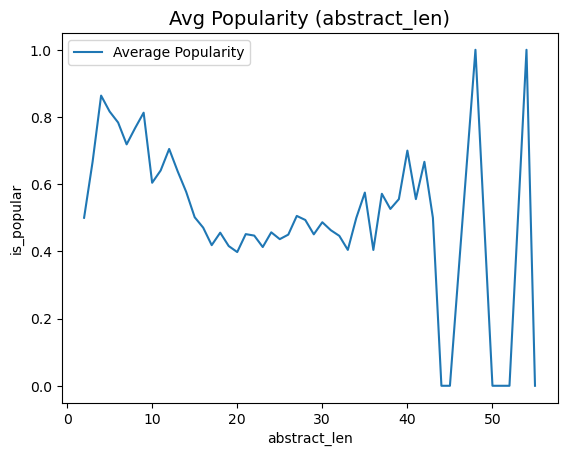

In [61]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_len)', fontsize=14)
print(train.corr()['is_popular']['abstract_len'])

<font size=6>headline length</font>

-0.009009345477795869


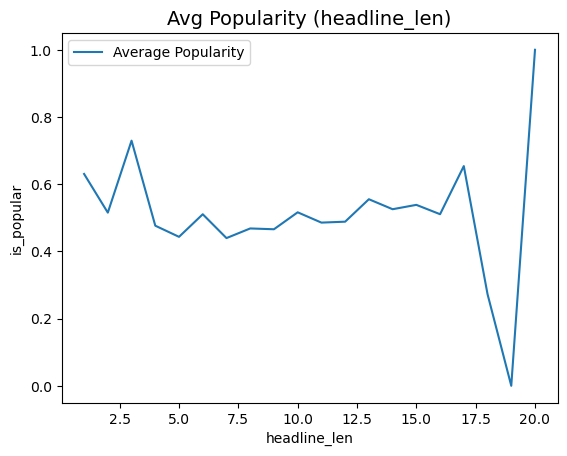

In [62]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('headline_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (headline_len)', fontsize=14)
print(train.corr()['is_popular']['headline_len'])

<font size=6>word count</font>

0.15087978485852482


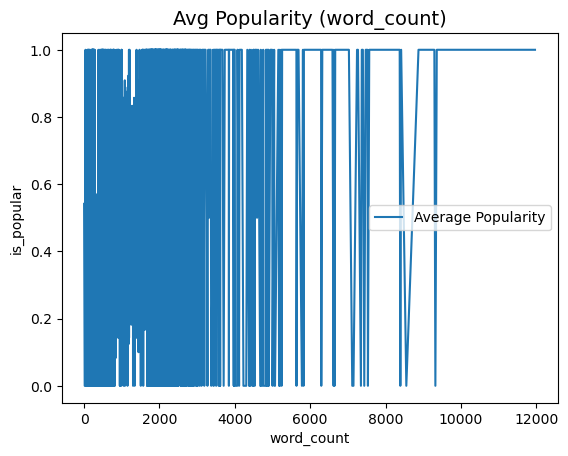

In [63]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('word_count').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (word_count)', fontsize=14)
print(train.corr()['is_popular']['word_count'])

0.08492949323226386


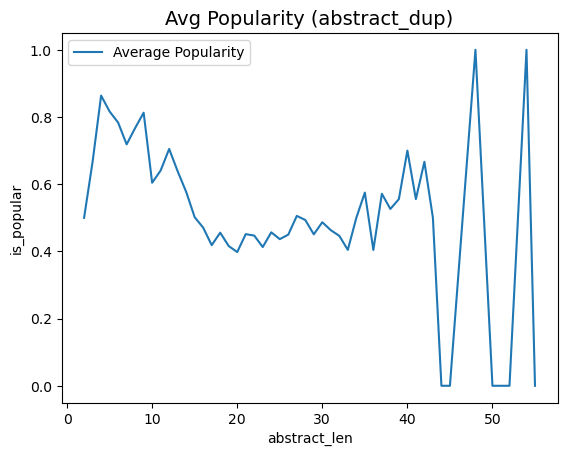

In [64]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_dup)', fontsize=14)
print(train.corr()['is_popular']['abstract_dup'])

<font size=6>word count</font>

0.05553097595060147


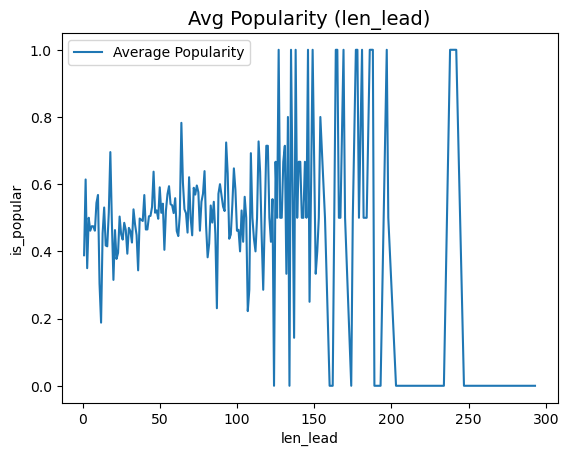

In [65]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('len_lead').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (len_lead)', fontsize=14)
print(train.corr()['is_popular']['len_lead'])

<font size = 6>Sentiment</font>

<font size = 5>punctuation removal</font>

In [66]:
punct_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(headline):
    for punc in punct_list:
        if punc in headline:
            headline = headline.replace(punc, ' ')
    return headline
train['clean_headline'] = train['headline'].apply(lambda x: remove_punctuation(x))

TypeError: 'Series' object is not callable

<font size = 5>textblob</font>

In [ ]:
text = "i am happy today."
blob = TextBlob(text)
# get the sentiment of the text
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)


In [ ]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_tb_polar'] = train['clean_headline'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_tb_polar_abs'] = train['sentiment_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_tb_subj'] = train['clean_headline'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_tb_pos'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
train['sentiment_tb_neg'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x <= 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_tb_polar'])
print(train.corr()['is_popular']['sentiment_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_tb_subj'])
print(train.corr()['is_popular']['sentiment_tb_pos'])
print(train.corr()['is_popular']['sentiment_tb_neg'])

-0.023040590015558835
0.012575981821205645
0.004317966797772634
-0.023576491372198995
0.023576491372199054


<font size = 5>vader</font>

In [ ]:
headline = 'today is a sunny day!'
analyzer = SentimentIntensityAnalyzer ()
sentiment_dict = analyzer.polarity_scores(headline)
print(sentiment_dict)

{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'compound': 0.4753}


In [ ]:
train['sentiment_vader_neg'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_vader_neu'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_vader_pos'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_vader_compound'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_vader_neg'])
print(train.corr()['is_popular']['sentiment_vader_neu'])
print(train.corr()['is_popular']['sentiment_vader_pos'])
print(train.corr()['is_popular']['sentiment_vader_compound'])
print(train.corr()['is_popular']['sentiment_vader_compound_abs'])

0.09393278420667187
-0.08444821535741638
0.015074865464558112
-0.06162453878193315
0.06332977895138316


<font size = 5>snownlp</font>

In [ ]:
headline = 'i am happy'
sentence = 'hello","why is it not working?!'
s = SnowNLP(headline)
print(s.sentiments)

0.1837233963534416


In [ ]:
def snow_score(headline):
    score = TextBlob(headline).sentiment[0]
    return score
train['sentiment_snow'] = train['clean_headline'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_snow_abs'] = train['sentiment_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_snow_pos'] = train['sentiment_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
train['sentiment_snow_neg'] = train['sentiment_snow'].apply(lambda x : 1 if x <= 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_snow'])
print(train.corr()['is_popular']['sentiment_snow_abs'])
print(train.corr()['is_popular']['sentiment_snow_pos'])
print(train.corr()['is_popular']['sentiment_snow_neg'])

-0.011896175304337312
0.04037706211799844
0.019203934869365672
-0.019203934869368413


<font size = 6>abstract</font>

In [ ]:
train['clean_abstract'] = train['abstract'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [ ]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_abstract_tb_polar'] = train['clean_abstract'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_abstract_tb_polar_abs'] = train['sentiment_abstract_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_abstract_tb_subj'] = train['clean_abstract'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_abstract_tb_pos'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
train['sentiment_abstract_tb_neg'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x <= 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_tb_polar'])
print(train.corr()['is_popular']['sentiment_abstract_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_abstract_tb_subj'])
print(train.corr()['is_popular']['sentiment_abstract_tb_pos'])
print(train.corr()['is_popular']['sentiment_abstract_tb_neg'])

-0.037196683066035914
-0.03704259561920765
-0.03737386373111884
-0.06832644861726417
0.06832644861726432


<font size = 5>vader</font>

In [ ]:
train['sentiment_abstract_vader_neg'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_abstract_vader_neu'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_abstract_vader_pos'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_abstract_vader_compound'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_abstract_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_abstract_vader_neg'])
print(train.corr()['is_popular']['sentiment_abstract_vader_neu'])
print(train.corr()['is_popular']['sentiment_abstract_vader_pos'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound_abs'])

0.11667773217491824
-0.11227157223772541
0.035839804278273275
-0.062120213227065776
0.06332977895138316


<font size = 5>snownlp</font>

In [ ]:
def snow_score(headline):
    score = TextBlob(headline).sentiment[0]
    return score
train['sentiment_abstract_snow'] = train['clean_abstract'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_abstract_snow_abs'] = train['sentiment_abstract_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_abstract_snow_pos'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
train['sentiment_abstract_snow_neg'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x <= 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_snow'])
print(train.corr()['is_popular']['sentiment_abstract_snow_abs'])
print(train.corr()['is_popular']['sentiment_abstract_snow_pos'])
print(train.corr()['is_popular']['sentiment_abstract_snow_neg'])

0.08756820068206324
-0.11002112703165913
0.019342588247869007
-0.01934258824787125


In [69]:
train.drop(columns=['web_url', 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker'])

,news_desk,section_name,type_of_material,word_count,subsection_name,pub_month,pub_day,pub_weekday,pub_time,abstract_len,...,feature_type_of_material,is_party,is_congress,is_president,is_ukrainian_russian_war,is_covid,is_storm,is_spell,is_crossword,is_game
14416,OpEd,Sunday Review,News Analysis,2394,NaN,8,27,4,16,10,...,0.9,0,0,0,0,0,0,0,0,0
12497,OpEd,Opinion,Op-Ed,1104,NaN,7,23,4,9,13,...,1.0,0,0,1,0,0,0,0,0,0
11095,OpEd,Opinion,Op-Ed,1379,NaN,6,26,5,11,14,...,1.0,0,0,0,0,0,0,0,0,0
33154,OpEd,Opinion,Op-Ed,232,NaN,8,23,1,9,11,...,1.0,0,0,0,0,0,0,0,0,0
10956,OpEd,Opinion,Op-Ed,1196,NaN,6,24,3,9,10,...,1.0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28372,Foreign,Today’s Paper,News,1365,NaN,5,20,4,17,23,...,0.5,0,0,0,1,0,0,0,0,0
11780,SpecialSections,At Home,News,1211,NaN,7,9,4,20,21,...,0.5,0,0,0,0,0,0,0,0,0
37695,Insider,Reader Center,News,920,NaN,11,13,6,8,29,...,0.5,0,0,0,0,0,0,0,0,0
32550,Headway,Headway,Interactive Feature,0,NaN,8,9,1,20,36,...,0.5,0,0,0,0,0,0,0,0,0


In [78]:
list = train.corr()['is_popular']
list = list.sort_values(key = lambda x : abs(x), ascending=False)
print(list)

is_popular                   1.000000
n_comment                    0.534608
group_by_news_desk           0.527639
group_by_subsection_name     0.527288
feature_news_desk            0.524174
feature_section_name         0.524174
feature_subsection_name      0.523312
group_by_section_name        0.513286
group_by_type_of_material    0.377151
feature_type_of_material     0.375541
is_president                 0.218398
is_party                     0.177102
word_count                   0.150880
is_game                      0.139314
abstract_len                -0.134882
is_noon                      0.133734
is_crossword                 0.113693
is_storm                     0.111416
is_congress                  0.107252
is_weekend                   0.094710
abstract_dup                 0.084929
headline_dup                 0.083014
is_spell                     0.078443
len_lead                     0.055531
is_ukrainian_russian_war     0.050766
pub_weekday                  0.041662
is_covid    

In [83]:
suit_attribute = []
for i in range(40):
    suit_attribute.append(list.index[i])
for col in train.columns:
    if col not in suit_attribute:
        train.drop(columns = col)
        
#print(list.columns)
#list.sort_values(list, key = lambda x: x[1])
#print(list)

IndexError: index 32 is out of bounds for axis 0 with size 32

<AxesSubplot:>

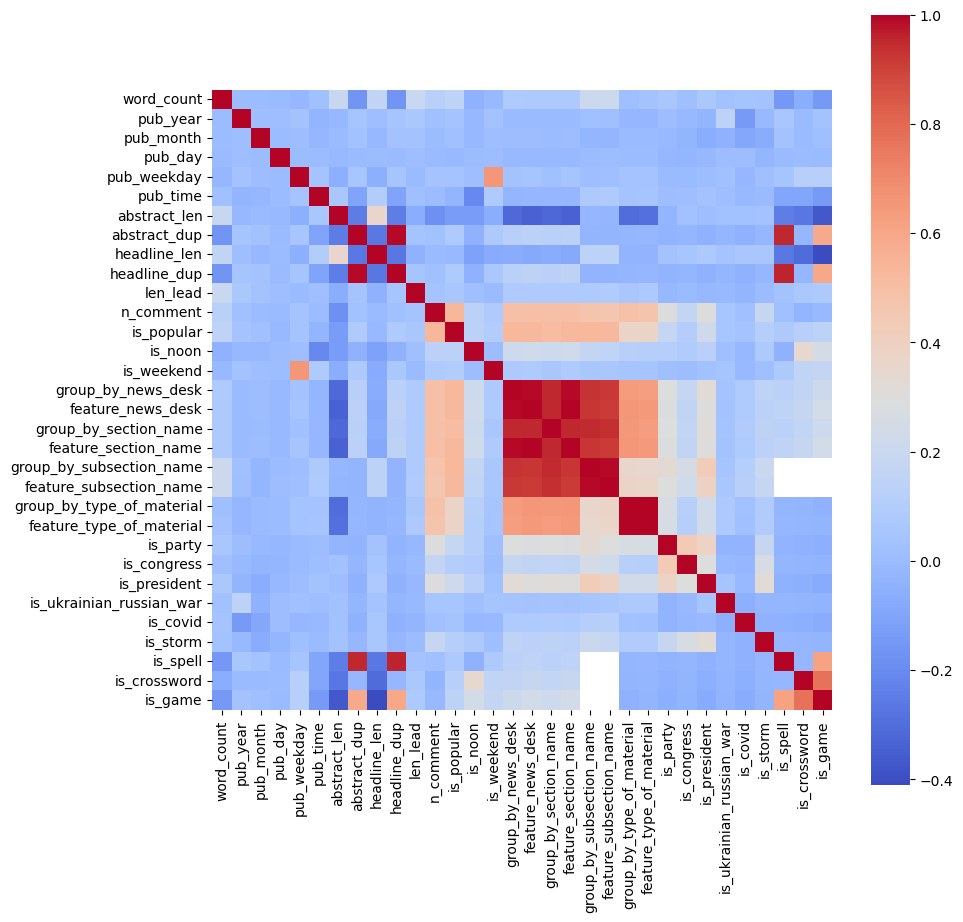

In [84]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True)

Index([ 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'len_lead', 
       'is_popular'],
      dtype='object')